## DATA301 Individual Project

Question: How much perfomance in prediction do I lose when I predict anemia using variables that are easier to measure and less invasive with respect to predictions based on blood tests?

In [1]:
import pandas as pd
import numpy as np
import xport
import sklearn
import seaborn as sns
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import f_regression
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import RandomizedSearchCV  
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score

In [2]:
# function to filter out columns and rows with too many NAs, threshold is 40% NAs in either the column or the row:
def naFilter(dataset):
    for i in dataset:
        if dataset[i].isna().sum()/len(dataset) > 0.5:
            dataset = dataset.drop(i, axis='columns')
    for i in range(len(dataset)):
        if dataset.loc[i].isna().sum()/len(dataset.loc[i]) > 0.5:
            dataset = dataset.drop(i)
    return dataset

# function to extract categorical and numerical column names
def catNamesAndNumNames(dataset):
    catNames = []
    numNames = []
    for i in dataset:
        if i == 'Anemia':
            pass
        elif len(pd.unique(dataset[i])) < 11:
                catNames.append(i)
        else:
            numNames.append(i)
    return catNames, numNames

In [3]:
combinedLabDataImputed = pd.read_csv('combinedLabData.csv')
combinedDemoEnvDataFinalTest = pd.read_csv('combined_data_imputed_final_test.csv')

In [4]:
anemiaInv = []
for i in range(len(combinedDemoEnvDataFinalTest)):
    if combinedDemoEnvDataFinalTest['DMDHRGND'][i] == 1 and combinedDemoEnvDataFinalTest['LBXHGB'][i] < 13:
        anemiaInv.append('True')
    elif combinedDemoEnvDataFinalTest['DMDHRGND'][i] == 2 and combinedDemoEnvDataFinalTest['LBXHGB'][i] < 12:
        anemiaInv.append('True')
    else:
        anemiaInv.append('False')

combinedDemoEnvDataFinalTest['Anemia'] = anemiaInv

In [5]:
anemiaDemoEnv = []
for i in range(len(combinedLabDataImputed)):
    if combinedLabDataImputed['DMDHRGND'][i] == 1 and combinedLabDataImputed['LBXHGB'][i] < 13:
        anemiaDemoEnv.append('True')
    elif combinedLabDataImputed['DMDHRGND'][i] == 2 and combinedLabDataImputed['LBXHGB'][i] < 12:
        anemiaDemoEnv.append('True')
    else:
        anemiaDemoEnv.append('False')

combinedLabDataImputed['Anemia'] = anemiaDemoEnv

In [6]:
combinedDemoEnvDataFinalTest['SEQN'] = combinedDemoEnvDataFinalTest['SEQN.1']
combinedDemoEnvDataFinalTest = combinedDemoEnvDataFinalTest.drop(['SEQN.1'], axis = 1)

In [104]:
newDataset =  pd.merge(combinedLabDataImputed.drop(['Anemia'], axis =1), combinedDemoEnvDataFinalTest.drop(['Anemia', 'DMDHRGND', 'LBDBANO', 'LBDEONO', 'LBDMONO', 'LBDNENO',
       'LBXBAPCT', 'LBXEOPCT', 'LBXHGB', 'LBXLYPCT', 'LBXMC', 'LBXMCVSI',
       'LBXMOPCT', 'LBXMPSI', 'LBXPLTSI', 'LBXRBCSI', 'LBXRDW',
       'LBXWBCSI'], axis =1), on='SEQN', how='left')

In [99]:
np.intersect1d(combinedLabDataImputed.columns, combinedDemoEnvDataFinalTest.columns)

array(['Anemia', 'DMDHRGND', 'LBDBANO', 'LBDEONO', 'LBDMONO', 'LBDNENO',
       'LBXBAPCT', 'LBXEOPCT', 'LBXHGB', 'LBXLYPCT', 'LBXMC', 'LBXMCVSI',
       'LBXMOPCT', 'LBXMPSI', 'LBXPLTSI', 'LBXRBCSI', 'LBXRDW',
       'LBXWBCSI', 'SEQN'], dtype=object)

In [105]:
newDataset

,SEQN,LBXWBCSI,LBXLYPCT,LBXMOPCT,LBXEOPCT,LBXBAPCT,LBDMONO,LBDNENO,LBDEONO,LBXRBCSI,...,MCQ300C,OSQ230,PAQ605,PAQ620,PAQ635,PAQ650,PAQ665,PAQ710,PAQ715,BMDSTATS
0,86094.0,9.3,38.1,7.7,2.0,0.6,0.7,4.8,0.2,5.35,...,2.0,2.0,2.0,1.0,2.0,1.0,1.0,4.0,3.0,1.0
1,99804.0,8.3,25.3,10.8,3.1,0.7,0.9,5.0,0.3,4.86,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,94012.0,11.1,25.8,7.5,3.5,0.9,0.8,6.9,0.4,5.02,...,1.0,2.0,1.0,1.0,2.0,2.0,1.0,2.0,8.0,1.0
3,94467.0,6.5,37.8,6.1,1.7,0.5,0.4,3.5,0.1,4.52,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,89039.0,7.2,39.2,6.7,8.9,0.8,0.5,3.2,0.6,4.49,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,86077.0,7.4,30.6,8.8,1.6,0.5,0.7,4.3,0.1,4.40,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,8.0,8.0,1.0
2496,97412.0,6.7,20.9,7.4,9.1,0.8,0.5,4.2,0.6,5.09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2497,100824.0,7.0,44.6,6.6,0.8,0.3,0.5,3.3,0.1,4.80,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2498,101166.0,5.3,40.2,10.0,7.8,1.1,0.5,2.2,0.4,4.77,...,2.0,2.0,2.0,2.0,1.0,2.0,1.0,2.0,8.0,1.0


In [106]:
num, cat = catNamesAndNumNames(newDataset)
numdata = newDataset[num]
catdata = newDataset[cat]

In [107]:
# Create an imputer object 
imputer_num = SimpleImputer(missing_values=np.nan, strategy='median')
imputer_cat = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
# Apply the imputer to the numerical data
numdataimputed = pd.DataFrame(imputer_num.fit_transform(numdata), columns=numdata.columns)

# Impute missing values with the mode for each column
catdataimputed = pd.DataFrame(imputer_cat.fit_transform(catdata), columns=catdata.columns)

In [108]:
newDataset = pd.concat([numdataimputed, catdataimputed], axis = 1)

In [109]:
seqn = newDataset['SEQN']
newDataset.pop('SEQN')
newDataset.insert(0, 'SEQN', seqn)
newDataset

,SEQN,LBDBANO,DMDHRGND,LBDBPBLC,LBDBCDLC,LBDTHGLC,LBDBSELC,LBDBMNLC,LBDIHGLC,LBDBGELC,...,LBDSUASI,BMXWT,BMXHT,BMXBMI,BMXLEG,BMXARML,BMXARMC,BMXWAIST,BMXSAD1,BMXSAD2
0,86094.0,1.000000e-01,1.0,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,1.0,1.0,...,523.4,81.3,168.0,28.8,40.1,36.5,36.4,93.7,21.7,22.1
1,99804.0,1.000000e-01,2.0,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,1.0,1.0,...,315.2,77.1,165.7,28.0,39.0,37.0,32.5,97.2,21.7,21.6
2,94012.0,1.000000e-01,2.0,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,1.0,1.0,...,511.5,92.5,170.5,31.8,38.0,39.2,34.5,110.0,21.7,21.6
3,94467.0,5.397605e-79,1.0,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,1.0,1.0,...,315.2,77.1,165.7,28.0,39.0,37.0,32.5,97.2,21.7,21.6
4,89039.0,1.000000e-01,2.0,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,1.0,1.0,...,315.2,77.1,165.7,28.0,39.0,37.0,32.5,97.2,21.7,21.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,86077.0,5.397605e-79,2.0,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,1.0,1.0,...,267.7,69.8,149.9,31.1,34.2,33.5,28.2,100.0,23.4,24.0
2496,97412.0,1.000000e-01,1.0,5.397605e-79,5.397605e-79,1.000000e+00,5.397605e-79,5.397605e-79,1.0,1.0,...,315.2,77.1,165.7,28.0,39.0,37.0,32.5,97.2,21.7,21.6
2497,100824.0,5.397605e-79,2.0,5.397605e-79,1.000000e+00,1.000000e+00,5.397605e-79,5.397605e-79,1.0,1.0,...,315.2,77.1,165.7,28.0,39.0,37.0,32.5,97.2,21.7,21.6
2498,101166.0,1.000000e-01,1.0,5.397605e-79,1.000000e+00,5.397605e-79,5.397605e-79,5.397605e-79,1.0,1.0,...,339.0,96.6,171.5,32.8,45.0,40.0,41.3,94.9,21.7,21.6


In order to measure performance of our models, we will compare the models using the following performance metrics to look at how much info is gained/lost when using external factors compared to blood test info: AUC/ROC, Accuracy, Precision and Sensitivity.

In [110]:
anemia = []
for i in range(len(newDataset)):
    if newDataset['DMDHRGND'][i] == 1 and newDataset['LBXHGB'][i] < 13:
        anemia.append('True')
    elif newDataset['DMDHRGND'][i] == 2 and newDataset['LBXHGB'][i] < 12:
        anemia.append('True')
    else:
        anemia.append('False')

newDataset['Anemia'] = anemia

In order to answer our question, I will look at the performances of the models using the invasive dataset, the demographic/environmental dataset and a combination of both .

## Invasive data models:

In [111]:
catVars, numVars = catNamesAndNumNames(combinedLabDataImputed.drop(['SEQN','LBXHGB','DMDHRGND','Anemia'], axis=1))
xtrain, xtest, ytrain, ytest = train_test_split(combinedLabDataImputed.drop(['SEQN','LBXHGB','DMDHRGND','Anemia'], axis=1), anemia, test_size=0.2, random_state=42)
categorical_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="most_frequent"))]
)
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="mean")), ("scaler", StandardScaler(with_mean=False))]
)
preprocessor = ColumnTransformer( 
    transformers=[
        ("num", numeric_transformer, numVars),
        ("cat", categorical_transformer, catVars)]
)

# 10% of the total variables will be selected
selection = SelectPercentile(chi2, percentile = 10)
pipe1 = Pipeline(
    steps = [("preprocessor", preprocessor),  ("rfc", RandomForestClassifier())]
)

random_grid = {'rfc__n_estimators': [200, 400, 600, 800, 1000],
               'rfc__max_features': ['log2', 'sqrt'],
               'rfc__max_depth': [10, 20, 30, 40, 50, 100],
               'rfc__min_samples_split': [2, 5, 10, 20],
               'rfc__min_samples_leaf': [1, 2, 4, 6],
               'rfc__bootstrap': [True, False]}
randomSearch = RandomizedSearchCV(pipe1, param_distributions = random_grid, scoring='accuracy', refit='accuracy', n_iter=10, cv=5, random_state=301)

randomSearch.fit(xtrain, ytrain)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer()),
                                                                                               ('scaler',
                                                                                                StandardScaler(with_mean=False))]),
                                                                               ['LBXWBCSI',
                                                                                'LBXLYPCT',
                                                                                'LBXMOPCT',
                                                                                'LBXEOPCT',
                                                                                'LBXBAPCT',
                                                                                'LBDMONO',
                                                                                'LBDNENO',
                                                                                'LBDEONO',
                                                                                'LBXRBCSI',
                                                                                'LBXMCVSI',
                                                                                'LBXMC',
                                                                                'LBXRDW',
                                                                                'LBXPLTSI',
                                                                                'LBXMPSI',
                                                                                'LBXBPB',
                                                                                '...
                                                                                'LBDVD3LC',
                                                                                'LBDVE3LC'])])),
                                             ('rfc',
                                              RandomForestClassifier())]),
                   param_distributions={'rfc__bootstrap': [True, False],
                                        'rfc__max_depth': [10, 20, 30, 40, 50,
                                                           100],
                                        'rfc__max_features': ['log2', 'sqrt'],
                                        'rfc__min_samples_leaf': [1, 2, 4, 6],
                                        'rfc__min_samples_split': [2, 5, 10,
                                                                   20],
                                        'rfc__n_estimators': [200, 400, 600,
                                                              800, 1000]},
                   random_state=301, refit='accuracy', scoring='accuracy')

In [112]:
randomSearch.best_score_ 

0.8805

In [113]:
predictions = randomSearch.best_estimator_.predict(xtest)

In [114]:
accuracy_score(ytest, predictions)
acc1 = accuracy_score(ytest, predictions)

In [115]:
print(classification_report(ytest, predictions))

              precision    recall  f1-score   support

       False       0.87      0.97      0.92       398
        True       0.79      0.41      0.54       102

    accuracy                           0.86       500
   macro avg       0.83      0.69      0.73       500
weighted avg       0.85      0.86      0.84       500



In [116]:
predictionsNum = randomSearch.best_estimator_.predict_proba(xtest)[:, 1]

In [117]:
ytestNum = []
for i in ytest:
    if i =="True":
        ytestNum.append(1)
    elif i=="False":
        ytestNum.append(0)

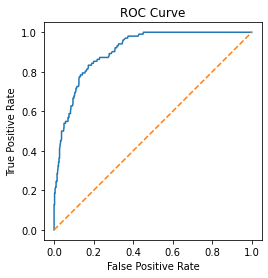

In [118]:
fpr, tpr, thresholds = roc_curve(ytestNum, predictionsNum)
fig = plt.figure()
ax = fig.add_subplot()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], '--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
ax.set_aspect('equal', adjustable='box')
plt.show()

In [119]:
print("ROC_AUC score: ",roc_auc_score(ytestNum, predictionsNum))
roc1 = roc_auc_score(ytestNum, predictionsNum)

ROC_AUC score:  0.9072076066607547


In [120]:
print("AUC-PR score: ",average_precision_score(ytestNum, predictionsNum))
aucpr1 = average_precision_score(ytestNum, predictionsNum)

AUC-PR score:  0.7214216365916601


In [121]:
pipe2 = Pipeline(steps=[("Preprocessing", preprocessor), ("mlp", MLPClassifier())])
mlp_grid = {'mlp__hidden_layer_sizes': [(50,), (100,), (200,), (400,)],
               'mlp__activation': ['identity','logistic','tanh', 'relu'],
               'mlp__solver': ['sgd', 'adam'],
               'mlp__alpha': [0.01, 0.001, 0.0001, 0.00001],
               'mlp__learning_rate': ['constant', 'invscaling', 'adaptive'],
               'mlp__learning_rate_init': [0.0001, 0.001, 0.01, 0.1],
               'mlp__early_stopping': [True],
               'mlp__max_iter': [200, 2000, 20000, 200000]}
mlpSearch = RandomizedSearchCV(pipe2, param_distributions = mlp_grid, n_iter=10, cv=5, scoring='accuracy', refit='accuracy', random_state=301)

mlpSearch.fit(xtrain, ytrain)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('Preprocessing',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer()),
                                                                                               ('scaler',
                                                                                                StandardScaler(with_mean=False))]),
                                                                               ['LBXWBCSI',
                                                                                'LBXLYPCT',
                                                                                'LBXMOPCT',
                                                                                'LBXEOPCT',
                                                                                'LBXBAPCT',
                                                                                'LBDMONO',
                                                                                'LBDNENO',
                                                                                'LBDEONO',
                                                                                'LBXRBCSI',
                                                                                'LBXMCVSI',
                                                                                'LBXMC',
                                                                                'LBXRDW',
                                                                                'LBXPLTSI',
                                                                                'LBXMPSI',
                                                                                'LBXBPB',...
                                        'mlp__alpha': [0.01, 0.001, 0.0001,
                                                       1e-05],
                                        'mlp__early_stopping': [True],
                                        'mlp__hidden_layer_sizes': [(50,),
                                                                    (100,),
                                                                    (200,),
                                                                    (400,)],
                                        'mlp__learning_rate': ['constant',
                                                               'invscaling',
                                                               'adaptive'],
                                        'mlp__learning_rate_init': [0.0001,
                                                                    0.001, 0.01,
                                                                    0.1],
                                        'mlp__max_iter': [200, 2000, 20000,
                                                          200000],
                                        'mlp__solver': ['sgd', 'adam']},
                   random_state=301, refit='accuracy', scoring='accuracy')

In [122]:
mlpSearch.best_score_ 

0.845

In [123]:
predictions2 = mlpSearch.best_estimator_.predict(xtest)

In [124]:
accuracy_score(ytest, predictions2)
acc2 = accuracy_score(ytest, predictions2)

In [125]:
print(classification_report(ytest, predictions2))

              precision    recall  f1-score   support

       False       0.84      0.97      0.90       398
        True       0.73      0.26      0.39       102

    accuracy                           0.83       500
   macro avg       0.78      0.62      0.64       500
weighted avg       0.82      0.83      0.80       500



In [126]:
predictionsNum2 = mlpSearch.best_estimator_.predict_proba(xtest)[:, 1]

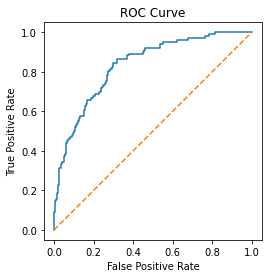

In [127]:
fpr, tpr, thresholds = roc_curve(ytestNum, predictionsNum2)
fig = plt.figure()
ax = fig.add_subplot()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], '--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
ax.set_aspect('equal', adjustable='box')
plt.show()

In [128]:
print("ROC_AUC score: ",roc_auc_score(ytestNum, predictionsNum2))
roc2 = roc_auc_score(ytestNum, predictionsNum2)

ROC_AUC score:  0.833308700364568


In [129]:
print("AUC-PR score: ",average_precision_score(ytestNum, predictionsNum2))
aucpr2 = average_precision_score(ytestNum, predictionsNum2)

AUC-PR score:  0.5958853107970947


In [131]:
pipe3 = Pipeline(steps=[("Preprocessing", preprocessor), ("gbc", GradientBoostingClassifier())])
grad_grid = {'gbc__loss': ['log_loss', 'exponential'],
               'gbc__learning_rate': [0.2, 0.1, 0.01, 0.001, 0.0001],
               'gbc__n_estimators': [20, 50, 100, 200, 400],
               'gbc__criterion': ['friedman_mse', 'squared_error'],
               'gbc__max_depth': [2,3,4,5],
               'gbc__min_samples_split': [2, 5, 10,20],
               'gbc__min_samples_leaf': [1, 2]}
gradSearch = RandomizedSearchCV(pipe3, param_distributions = grad_grid,n_iter=10, cv=10, scoring='accuracy', refit='accuracy',random_state=301)

gradSearch.fit(xtrain, ytrain)

RandomizedSearchCV(cv=10,
                   estimator=Pipeline(steps=[('Preprocessing',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer()),
                                                                                               ('scaler',
                                                                                                StandardScaler(with_mean=False))]),
                                                                               ['LBXWBCSI',
                                                                                'LBXLYPCT',
                                                                                'LBXMOPCT',
                                                                                'LBXEOPCT',
                                                                                'LBXBAPCT',
                                                                                'LBDMONO',
                                                                                'LBDNENO',
                                                                                'LBDEONO',
                                                                                'LBXRBCSI',
                                                                                'LBXMCVSI',
                                                                                'LBXMC',
                                                                                'LBXRDW',
                                                                                'LBXPLTSI',
                                                                                'LBXMPSI',
                                                                                'LBXBPB'...
                                              GradientBoostingClassifier())]),
                   param_distributions={'gbc__criterion': ['friedman_mse',
                                                           'squared_error'],
                                        'gbc__learning_rate': [0.2, 0.1, 0.01,
                                                               0.001, 0.0001],
                                        'gbc__loss': ['log_loss',
                                                      'exponential'],
                                        'gbc__max_depth': [2, 3, 4, 5],
                                        'gbc__min_samples_leaf': [1, 2],
                                        'gbc__min_samples_split': [2, 5, 10,
                                                                   20],
                                        'gbc__n_estimators': [20, 50, 100, 200,
                                                              400]},
                   random_state=301, refit='accuracy', scoring='accuracy')

In [132]:
gradSearch.best_score_

0.897

In [133]:
predictions3 = gradSearch.best_estimator_.predict(xtest)

In [134]:
accuracy_score(ytest, predictions3)
acc3 = accuracy_score(ytest, predictions3)

In [135]:
print(classification_report(ytest, predictions3))

              precision    recall  f1-score   support

       False       0.89      0.97      0.93       398
        True       0.82      0.52      0.63       102

    accuracy                           0.88       500
   macro avg       0.85      0.74      0.78       500
weighted avg       0.87      0.88      0.87       500



In [136]:
predictionsNum3 = gradSearch.best_estimator_.predict_proba(xtest)[:, 1]

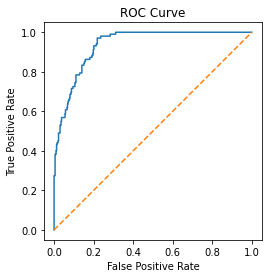

In [137]:
fpr, tpr, thresholds = roc_curve(ytestNum, predictionsNum3)
fig = plt.figure()
ax = fig.add_subplot()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], '--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
ax.set_aspect('equal', adjustable='box')
plt.show()

In [138]:
print("ROC_AUC score: ",roc_auc_score(ytestNum, predictionsNum3))
roc3 = roc_auc_score(ytestNum, predictionsNum3)

ROC_AUC score:  0.935806483397379


In [139]:
print("AUC-PR score: ",average_precision_score(ytestNum, predictionsNum3))
aucpr3 = average_precision_score(ytestNum, predictionsNum3)

AUC-PR score:  0.7997761748124788


## Demographic/environmental dataset

In [140]:
#newdataset variables:
catVars, numVars = catNamesAndNumNames(combinedLabDataImputed.drop(['SEQN','LBXHGB','DMDHRGND'], axis=1))
xtrain, xtest, ytrain, ytest = train_test_split(combinedLabDataImputed.drop(['SEQN','LBXHGB','DMDHRGND'], axis=1), anemiaDemoEnv, test_size=0.2, random_state=42)
categorical_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="most_frequent"))]
)
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="mean")), ("scaler", StandardScaler(with_mean=False))]
)
preprocessor = ColumnTransformer( 
    transformers=[
        ("num", numeric_transformer, numVars),
        ("cat", categorical_transformer, catVars)]
)

# 10% of the total variables will be selected
selection = SelectPercentile(chi2, percentile = 10)
pipe4 = Pipeline(
    steps = [("preprocessor", preprocessor),  ("rfc", RandomForestClassifier())]
)

random_grid = {'rfc__n_estimators': [200, 400, 600, 800, 1000],
               'rfc__max_features': ['log2', 'sqrt'],
               'rfc__max_depth': [10, 20, 30, 40, 50, 100],
               'rfc__min_samples_split': [2, 5, 10, 20],
               'rfc__min_samples_leaf': [1, 2, 4, 6],
               'rfc__bootstrap': [True, False]}
randomSearch = RandomizedSearchCV(pipe4, param_distributions = random_grid, scoring='accuracy', refit='accuracy', n_iter=10, cv=5, random_state=301)

randomSearch.fit(xtrain, ytrain)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer()),
                                                                                               ('scaler',
                                                                                                StandardScaler(with_mean=False))]),
                                                                               ['LBXWBCSI',
                                                                                'LBXLYPCT',
                                                                                'LBXMOPCT',
                                                                                'LBXEOPCT',
                                                                                'LBXBAPCT',
                                                                                'LBDMONO',
                                                                                'LBDNENO',
                                                                                'LBDEONO',
                                                                                'LBXRBCSI',
                                                                                'LBXMCVSI',
                                                                                'LBXMC',
                                                                                'LBXRDW',
                                                                                'LBXPLTSI',
                                                                                'LBXMPSI',
                                                                                'LBXBPB',
                                                                                '...
                                                                                'LBDVD3LC',
                                                                                'LBDVE3LC'])])),
                                             ('rfc',
                                              RandomForestClassifier())]),
                   param_distributions={'rfc__bootstrap': [True, False],
                                        'rfc__max_depth': [10, 20, 30, 40, 50,
                                                           100],
                                        'rfc__max_features': ['log2', 'sqrt'],
                                        'rfc__min_samples_leaf': [1, 2, 4, 6],
                                        'rfc__min_samples_split': [2, 5, 10,
                                                                   20],
                                        'rfc__n_estimators': [200, 400, 600,
                                                              800, 1000]},
                   random_state=301, refit='accuracy', scoring='accuracy')

In [141]:
randomSearch.best_score_ 

0.8780000000000001

In [142]:
predictions4 = randomSearch.best_estimator_.predict(xtest)

In [143]:
accuracy_score(ytest, predictions4)
acc4 = accuracy_score(ytest, predictions4)

In [144]:
print(classification_report(ytest, predictions4))

              precision    recall  f1-score   support

       False       0.87      0.97      0.91       398
        True       0.78      0.41      0.54       102

    accuracy                           0.86       500
   macro avg       0.82      0.69      0.73       500
weighted avg       0.85      0.86      0.84       500



In [145]:
predictionsNum4 = randomSearch.best_estimator_.predict_proba(xtest)[:, 1]

In [146]:
ytestNum = []
for i in ytest:
    if i =="True":
        ytestNum.append(1)
    elif i=="False":
        ytestNum.append(0)

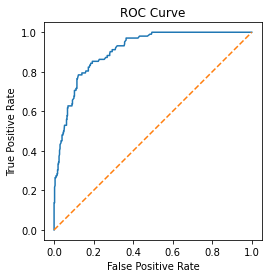

In [147]:
fpr, tpr, thresholds = roc_curve(ytestNum, predictionsNum4)
fig = plt.figure()
ax = fig.add_subplot()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], '--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
ax.set_aspect('equal', adjustable='box')
plt.show()

In [148]:
print("ROC_AUC score: ",roc_auc_score(ytestNum, predictionsNum4))
roc4 = roc_auc_score(ytestNum, predictionsNum4)

ROC_AUC score:  0.9066533648635332


In [149]:
print("AUC-PR score: ",average_precision_score(ytestNum, predictionsNum4))
aucpr4 = average_precision_score(ytestNum, predictionsNum4)

AUC-PR score:  0.7293015774438893


In [150]:
pipe5 = Pipeline(steps=[("Preprocessing", preprocessor), ("mlp", MLPClassifier())])
mlp_grid = {'mlp__hidden_layer_sizes': [(50,), (100,), (200,), (400,)],
               'mlp__activation': ['identity','logistic','tanh', 'relu'],
               'mlp__solver': ['sgd', 'adam'],
               'mlp__alpha': [0.01, 0.001, 0.0001, 0.00001],
               'mlp__learning_rate': ['constant', 'invscaling', 'adaptive'],
               'mlp__learning_rate_init': [0.0001, 0.001, 0.01, 0.1],
               'mlp__early_stopping': [True],
               'mlp__max_iter': [200, 2000, 20000, 200000]}
mlpSearch = RandomizedSearchCV(pipe5, param_distributions = mlp_grid, n_iter=10, cv=5, scoring='accuracy', refit='accuracy', random_state=301)

mlpSearch.fit(xtrain, ytrain)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('Preprocessing',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer()),
                                                                                               ('scaler',
                                                                                                StandardScaler(with_mean=False))]),
                                                                               ['LBXWBCSI',
                                                                                'LBXLYPCT',
                                                                                'LBXMOPCT',
                                                                                'LBXEOPCT',
                                                                                'LBXBAPCT',
                                                                                'LBDMONO',
                                                                                'LBDNENO',
                                                                                'LBDEONO',
                                                                                'LBXRBCSI',
                                                                                'LBXMCVSI',
                                                                                'LBXMC',
                                                                                'LBXRDW',
                                                                                'LBXPLTSI',
                                                                                'LBXMPSI',
                                                                                'LBXBPB',...
                                        'mlp__alpha': [0.01, 0.001, 0.0001,
                                                       1e-05],
                                        'mlp__early_stopping': [True],
                                        'mlp__hidden_layer_sizes': [(50,),
                                                                    (100,),
                                                                    (200,),
                                                                    (400,)],
                                        'mlp__learning_rate': ['constant',
                                                               'invscaling',
                                                               'adaptive'],
                                        'mlp__learning_rate_init': [0.0001,
                                                                    0.001, 0.01,
                                                                    0.1],
                                        'mlp__max_iter': [200, 2000, 20000,
                                                          200000],
                                        'mlp__solver': ['sgd', 'adam']},
                   random_state=301, refit='accuracy', scoring='accuracy')

In [151]:
mlpSearch.best_score_

0.859

In [152]:
predictions5 = mlpSearch.best_estimator_.predict(xtest)

In [153]:
accuracy_score(ytest, predictions5)
acc5 = accuracy_score(ytest, predictions5)

In [154]:
print(classification_report(ytest, predictions5))

              precision    recall  f1-score   support

       False       0.87      0.92      0.90       398
        True       0.60      0.46      0.52       102

    accuracy                           0.83       500
   macro avg       0.74      0.69      0.71       500
weighted avg       0.82      0.83      0.82       500



In [155]:
predictionsNum5 = randomSearch.best_estimator_.predict_proba(xtest)[:, 1]

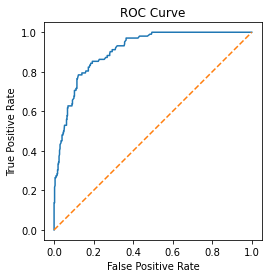

In [156]:
fpr, tpr, thresholds = roc_curve(ytestNum, predictionsNum5)
fig = plt.figure()
ax = fig.add_subplot()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], '--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
ax.set_aspect('equal', adjustable='box')
plt.show()

In [157]:
print("ROC_AUC score: ",roc_auc_score(ytestNum, predictionsNum5))
roc5 = roc_auc_score(ytestNum, predictionsNum5)

ROC_AUC score:  0.9066533648635332


In [158]:
print("AUC-PR score: ",average_precision_score(ytestNum, predictionsNum5))
aucpr5 = average_precision_score(ytestNum, predictionsNum5)

AUC-PR score:  0.7293015774438893


In [159]:
pipe6 = Pipeline(steps=[("Preprocessing", preprocessor), ("gbc", GradientBoostingClassifier())])
grad_grid = {'gbc__loss': ['log_loss', 'exponential'],
               'gbc__learning_rate': [0.2, 0.1, 0.01, 0.001, 0.0001],
               'gbc__n_estimators': [20, 50, 100, 200, 400],
               'gbc__criterion': ['friedman_mse', 'squared_error'],
               'gbc__max_depth': [2,3,4,5],
               'gbc__min_samples_split': [2, 5, 10,20],
               'gbc__min_samples_leaf': [1, 2]}
gradSearch = RandomizedSearchCV(pipe6, param_distributions = grad_grid,n_iter=10, cv=10, scoring='accuracy', refit='accuracy',random_state=301)

gradSearch.fit(xtrain, ytrain)

RandomizedSearchCV(cv=10,
                   estimator=Pipeline(steps=[('Preprocessing',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer()),
                                                                                               ('scaler',
                                                                                                StandardScaler(with_mean=False))]),
                                                                               ['LBXWBCSI',
                                                                                'LBXLYPCT',
                                                                                'LBXMOPCT',
                                                                                'LBXEOPCT',
                                                                                'LBXBAPCT',
                                                                                'LBDMONO',
                                                                                'LBDNENO',
                                                                                'LBDEONO',
                                                                                'LBXRBCSI',
                                                                                'LBXMCVSI',
                                                                                'LBXMC',
                                                                                'LBXRDW',
                                                                                'LBXPLTSI',
                                                                                'LBXMPSI',
                                                                                'LBXBPB'...
                                              GradientBoostingClassifier())]),
                   param_distributions={'gbc__criterion': ['friedman_mse',
                                                           'squared_error'],
                                        'gbc__learning_rate': [0.2, 0.1, 0.01,
                                                               0.001, 0.0001],
                                        'gbc__loss': ['log_loss',
                                                      'exponential'],
                                        'gbc__max_depth': [2, 3, 4, 5],
                                        'gbc__min_samples_leaf': [1, 2],
                                        'gbc__min_samples_split': [2, 5, 10,
                                                                   20],
                                        'gbc__n_estimators': [20, 50, 100, 200,
                                                              400]},
                   random_state=301, refit='accuracy', scoring='accuracy')

In [160]:
gradSearch.best_score_

0.897

In [161]:
predictions6 = gradSearch.best_estimator_.predict(xtest)

In [162]:
accuracy_score(ytest, predictions6)
acc6 = accuracy_score(ytest, predictions6)

In [163]:
print(classification_report(ytest, predictions6))

              precision    recall  f1-score   support

       False       0.89      0.97      0.93       398
        True       0.82      0.52      0.63       102

    accuracy                           0.88       500
   macro avg       0.85      0.74      0.78       500
weighted avg       0.87      0.88      0.87       500



In [164]:
predictionsNum6 = gradSearch.best_estimator_.predict_proba(xtest)[:, 1]

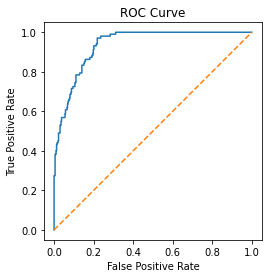

In [165]:
fpr, tpr, thresholds = roc_curve(ytestNum, predictionsNum6)
fig = plt.figure()
ax = fig.add_subplot()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], '--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
ax.set_aspect('equal', adjustable='box')
plt.show()

In [166]:
print("ROC_AUC score: ",roc_auc_score(ytestNum, predictionsNum6))
roc6 = roc_auc_score(ytestNum, predictionsNum6)

ROC_AUC score:  0.935806483397379


In [167]:
print("AUC-PR score: ",average_precision_score(ytestNum, predictionsNum6))
aucpr6 = average_precision_score(ytestNum, predictionsNum6)

AUC-PR score:  0.7997761748124788


## Combined dataset

In [168]:
#newdataset variables:
catVars, numVars = catNamesAndNumNames(newDataset.drop(['SEQN','LBXHGB','DMDHRGND', 'Anemia'], axis=1))
xtrain, xtest, ytrain, ytest = train_test_split(newDataset.drop(['SEQN','LBXHGB','DMDHRGND', 'Anemia'], axis=1), newDataset['Anemia'], test_size=0.2, random_state=42)
categorical_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="most_frequent"))]
)
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="mean")), ("scaler", StandardScaler(with_mean=False))]
)
preprocessor = ColumnTransformer( 
    transformers=[
        ("num", numeric_transformer, numVars),
        ("cat", categorical_transformer, catVars)]
)

# 10% of the total variables will be selected
selection = SelectPercentile(chi2, percentile = 10)
pipe7 = Pipeline(
    steps = [("preprocessor", preprocessor),  ("rfc", RandomForestClassifier())]
)

random_grid = {'rfc__n_estimators': [200, 400, 600, 800, 1000],
               'rfc__max_features': ['log2', 'sqrt'],
               'rfc__max_depth': [10, 20, 30, 40, 50, 100],
               'rfc__min_samples_split': [2, 5, 10, 20],
               'rfc__min_samples_leaf': [1, 2, 4, 6],
               'rfc__bootstrap': [True, False]}
randomSearch = RandomizedSearchCV(pipe7, param_distributions = random_grid, scoring='accuracy', refit='accuracy', n_iter=10, cv=5, random_state=301)

randomSearch.fit(xtrain, ytrain)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer()),
                                                                                               ('scaler',
                                                                                                StandardScaler(with_mean=False))]),
                                                                               ['LBXWBCSI',
                                                                                'LBXLYPCT',
                                                                                'LBXMOPCT',
                                                                                'LBXEOPCT',
                                                                                'LBXBAPCT',
                                                                                'LBDMONO',
                                                                                'LBDNENO',
                                                                                'LBDEONO',
                                                                                'LBXRBCSI',
                                                                                'LBXMCVSI',
                                                                                'LBXMC',
                                                                                'LBXRDW',
                                                                                'LBXPLTSI',
                                                                                'LBXMPSI',
                                                                                'LBXBPB',
                                                                                '...
                                                                                'MCQ160O',
                                                                                'MCQ203', ...])])),
                                             ('rfc',
                                              RandomForestClassifier())]),
                   param_distributions={'rfc__bootstrap': [True, False],
                                        'rfc__max_depth': [10, 20, 30, 40, 50,
                                                           100],
                                        'rfc__max_features': ['log2', 'sqrt'],
                                        'rfc__min_samples_leaf': [1, 2, 4, 6],
                                        'rfc__min_samples_split': [2, 5, 10,
                                                                   20],
                                        'rfc__n_estimators': [200, 400, 600,
                                                              800, 1000]},
                   random_state=301, refit='accuracy', scoring='accuracy')

In [169]:
for i in newDataset.columns:
    print(i)

SEQN
LBDBANO
DMDHRGND
LBDBPBLC
LBDBCDLC
LBDTHGLC
LBDBSELC
LBDBMNLC
LBDIHGLC
LBDBGELC
LBDBGMLC
LBDVIDLC
LBDVD2LC
LBDVD3LC
LBDVE3LC
MCQ010
MCQ053
MCQ080
MCQ092
MCQ160A
MCQ160N
MCQ160B
MCQ160C
MCQ160D
MCQ160E
MCQ160F
MCQ160G
MCQ160M
MCQ160K
MCQ160L
MCQ160O
MCQ203
MCQ220
MCQ300A
MCQ300B
MCQ300C
OSQ230
PAQ605
PAQ620
PAQ635
PAQ650
PAQ665
PAQ710
PAQ715
BMDSTATS
LBXWBCSI
LBXLYPCT
LBXMOPCT
LBXEOPCT
LBXBAPCT
LBDMONO
LBDNENO
LBDEONO
LBXRBCSI
LBXHGB
LBXMCVSI
LBXMC
LBXRDW
LBXPLTSI
LBXMPSI
LBXBPB
LBXBCD
LBXTHG
LBXBSE
LBXBMN
LBXIHG
LBXBGE
LBDHDD
LBXVIDMS
LBXVD2MS
LBXVE3MS
LBXNEPCT
LBDLYMNO
LBXHCT
LBXMCHSI
LBXSAL
LBDSALSI
LBXSAPSI
LBXSASSI
LBXSATSI
LBXSBU
LBDSBUSI
LBXSC3SI
LBXSCA
LBDSCASI
LBXSCH
LBDSCHSI
LBXSCK
LBXSCLSI
LBXSCR
LBDSCRSI
LBXSGB
LBDSGBSI
LBXSGL
LBDSGLSI
LBXSGTSI
LBXSIR
LBDSIRSI
LBXSKSI
LBXSLDSI
LBXSNASI
LBXSOSSI
LBXSPH
LBDSPHSI
LBXSTB
LBDSTBSI
LBXSTP
LBDSTPSI
LBXSTR
LBDSTRSI
LBXSUA
LBDSUASI
BMXWT
BMXHT
BMXBMI
BMXLEG
BMXARML
BMXARMC
BMXWAIST
BMXSAD1
BMXSAD2
Anemia


In [170]:
randomSearch.best_score_ 

0.869

In [171]:
predictions7 = randomSearch.best_estimator_.predict(xtest)

In [172]:
ytestNum = []
for i in ytest:
    if i =="True":
        ytestNum.append(1)
    elif i=="False":
        ytestNum.append(0)

In [173]:
accuracy_score(ytest, predictions7)
acc7 = accuracy_score(ytest, predictions7)

In [174]:
print(classification_report(ytest, predictions7))

              precision    recall  f1-score   support

       False       0.85      0.98      0.91       398
        True       0.79      0.33      0.47       102

    accuracy                           0.85       500
   macro avg       0.82      0.66      0.69       500
weighted avg       0.84      0.85      0.82       500



In [175]:
predictionsNum7 = randomSearch.best_estimator_.predict_proba(xtest)[:, 1]

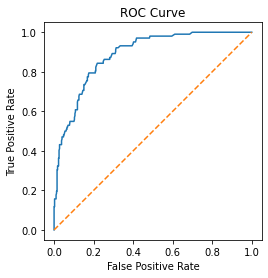

In [176]:
fpr, tpr, thresholds = roc_curve(ytestNum, predictionsNum7)
fig = plt.figure()
ax = fig.add_subplot()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], '--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
ax.set_aspect('equal', adjustable='box')

In [177]:
print("ROC_AUC score: ",roc_auc_score(ytestNum, predictionsNum7))
roc7 = roc_auc_score(ytestNum, predictionsNum7)

ROC_AUC score:  0.8860232535225145


In [178]:
print("AUC-PR score: ",average_precision_score(ytestNum, predictionsNum7))
aucpr7 = average_precision_score(ytestNum, predictionsNum7)

AUC-PR score:  0.6834002042572768


In [278]:
pipe8 = Pipeline(steps=[("Preprocessing", preprocessor), ("mlp", MLPClassifier())])
mlp_grid = {'mlp__hidden_layer_sizes': [(50,), (100,), (200,), (400,)],
               'mlp__activation': ['identity','logistic','tanh', 'relu'],
               'mlp__solver': ['sgd', 'adam'],
               'mlp__alpha': [0.01, 0.001, 0.0001, 0.00001],
               'mlp__learning_rate_init': [0.0001, 0.001, 0.01, 0.1],
               'mlp__early_stopping': [True],
               'mlp__max_iter': [200, 2000, 20000, 200000]}
mlpSearch = RandomizedSearchCV(pipe8, param_distributions = mlp_grid, n_iter=1000, cv=10, scoring='accuracy', refit=True, random_state=301)

mlpSearch.fit(xtrain, ytrain)

c:\Users\dl668\anaconda3\lib\site-packages\sklearn\utils\extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
c:\Users\dl668\anaconda3\lib\site-packages\sklearn\utils\extmath.py:193: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
c:\Users\dl668\anaconda3\lib\site-packages\sklearn\utils\extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
c:\Users\dl668\anaconda3\lib\site-packages\sklearn\utils\extmath.py:193: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
c:\Users\dl668\anaconda3\lib\site-packages\sklearn\utils\extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
c:\Users\dl668\anaconda3\lib\site-packages\sklearn\utils\extmath.py:193: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
c:\Users\dl668\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:338: RuntimeWarning: overflow encountered in double_scalars
  values += np.dot(s, s)
c:\U

RandomizedSearchCV(cv=10,
                   estimator=Pipeline(steps=[('Preprocessing',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer()),
                                                                                               ('scaler',
                                                                                                StandardScaler(with_mean=False))]),
                                                                               ['LBXWBCSI',
                                                                                'LBXLYPCT',
                                                                                'LBXMOPCT',
                                                                                'LBXEOPCT',
                                                                                'LBXBAPCT',
                                                                                'LBDMONO',
                                                                                'LBDNENO',
                                                                                'LBDEONO',
                                                                                'LBXRBCSI',
                                                                                'LBXMCVSI',
                                                                                'LBXMC',
                                                                                'LBXRDW',
                                                                                'LBXPLTSI',
                                                                                'LBXMPSI',
                                                                                'LBXBPB'...
                   param_distributions={'mlp__activation': ['identity',
                                                            'logistic', 'tanh',
                                                            'relu'],
                                        'mlp__alpha': [0.01, 0.001, 0.0001,
                                                       1e-05],
                                        'mlp__early_stopping': [True],
                                        'mlp__hidden_layer_sizes': [(50,),
                                                                    (100,),
                                                                    (200,),
                                                                    (400,)],
                                        'mlp__learning_rate_init': [0.0001,
                                                                    0.001, 0.01,
                                                                    0.1],
                                        'mlp__max_iter': [200, 2000, 20000,
                                                          200000],
                                        'mlp__solver': ['sgd', 'adam']},
                   random_state=301, scoring='accuracy')

In [288]:
mlpSearch.best_score_

0.8515

In [289]:
predictions8 = mlpSearch.best_estimator_.predict(xtest)

In [290]:
pd.unique(predictions8)

array(['False', 'True'], dtype='<U5')

In [291]:
accuracy_score(ytest, predictions8)
acc8 = accuracy_score(ytest, predictions8)

In [292]:
print(classification_report(ytest, predictions8))

              precision    recall  f1-score   support

       False       0.84      0.96      0.90       398
        True       0.67      0.30      0.42       102

    accuracy                           0.83       500
   macro avg       0.76      0.63      0.66       500
weighted avg       0.81      0.83      0.80       500



In [293]:
predictionsNum8 = mlpSearch.best_estimator_.predict_proba(xtest)[:, 1]

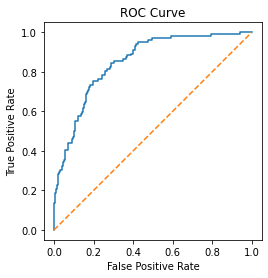

In [294]:
fpr, tpr, thresholds = roc_curve(ytestNum, predictionsNum8)
fig = plt.figure()
ax = fig.add_subplot()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], '--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
ax.set_aspect('equal', adjustable='box')

In [295]:
print("ROC_AUC score: ",roc_auc_score(ytestNum, predictionsNum8))
roc8 = roc_auc_score(ytestNum, predictionsNum8)

ROC_AUC score:  0.8499113213124446


In [296]:
print("AUC-PR score: ",average_precision_score(ytestNum, predictionsNum8))
aucpr8 = average_precision_score(ytestNum, predictionsNum8)

AUC-PR score:  0.6237990679147957


In [297]:
pipe9 = Pipeline(steps=[("Preprocessing", preprocessor), ("gbc", GradientBoostingClassifier())])
grad_grid = {'gbc__loss': ['log_loss', 'exponential'],
               'gbc__learning_rate': [0.2, 0.1, 0.01, 0.001, 0.0001],
               'gbc__n_estimators': [20, 50, 100, 200, 400],
               'gbc__criterion': ['friedman_mse', 'squared_error'],
               'gbc__max_depth': [2,3,4,5],
               'gbc__min_samples_split': [2, 5, 10,20],
               'gbc__min_samples_leaf': [1, 2]}
gradSearch = RandomizedSearchCV(pipe9, param_distributions = grad_grid,n_iter=10, cv=10, scoring='accuracy', refit='accuracy',random_state=301)

gradSearch.fit(xtrain, ytrain)

In [ ]:
gradSearch.best_score_

0.8949999999999999

In [ ]:
predictions9 = gradSearch.best_estimator_.predict(xtest)

In [ ]:
accuracy_score(ytest, predictions9)
acc9 = accuracy_score(ytest, predictions9)

In [ ]:
print(classification_report(ytest, predictions9))

              precision    recall  f1-score   support

       False       0.90      0.95      0.93       398
        True       0.76      0.59      0.66       102

    accuracy                           0.88       500
   macro avg       0.83      0.77      0.79       500
weighted avg       0.87      0.88      0.87       500



In [ ]:
predictionsNum9 = gradSearch.best_estimator_.predict_proba(xtest)[:, 1]

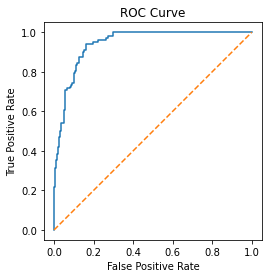

In [ ]:
fpr, tpr, thresholds = roc_curve(ytestNum, predictionsNum9)
fig = plt.figure()
ax = fig.add_subplot()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], '--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
ax.set_aspect('equal', adjustable='box')
plt.show()

In [ ]:
print("ROC_AUC score: ",roc_auc_score(ytestNum, predictionsNum9))
roc9 = roc_auc_score(ytestNum, predictionsNum9)

ROC_AUC score:  0.9433441718395901


In [ ]:
print("AUC-PR score: ",average_precision_score(ytestNum, predictionsNum9))
aucpr9 = average_precision_score(ytestNum, predictionsNum9)

AUC-PR score:  0.8075475470007396


In [ ]:
perfMetricsData = {"Statistics:": ['Accuracy', 'AUC-PR score', 'ROC-AUC score'],
                  "Invasive data Random Forest": [acc1,  aucpr1, roc1],
                  "Invasive data Gradient Boost": [acc2, aucpr2, roc2],
                  "Invasive data Multi Layer Perceptron:": [acc3, aucpr3, roc3],
                  "Demographic/Environmental data Random Forest": [acc4,  aucpr4, roc4],
                  "Demographic/Environmental data  Gradient Boost": [acc5, aucpr5, roc5],
                  "Demographic/Environmental data  Multi Layer Perceptron:": [acc6, aucpr6, roc6],
                  "Combined data Random Forest": [acc7,  aucpr7, roc7],
                  "Combined data Gradient Boost": [acc8, aucpr8, roc8],
                  "Combined data Multi Layer Perceptron:": [acc9, aucpr9, roc9],}
perfMetrics = pd.DataFrame(perfMetricsData)
perfMetrics

,Statistics:,Invasive data Random Forest,Invasive data Gradient Boost,Invasive data Multi Layer Perceptron:,Demographic/Environmental data Random Forest,Demographic/Environmental data Gradient Boost,Demographic/Environmental data Multi Layer Perceptron:,Combined data Random Forest,Combined data Gradient Boost,Combined data Multi Layer Perceptron:
0,Accuracy,0.858000,0.830000,0.878000,0.856000,0.828000,0.878000,0.846000,0.796000,0.878000
1,AUC-PR score,0.721422,0.595885,0.799776,0.729302,0.729302,0.799776,0.683400,0.288977,0.807548
2,ROC-AUC score,0.907208,0.833309,0.935806,0.906653,0.906653,0.935806,0.886023,0.647970,0.943344
